# Feature Selection Using LASSO
The `scikit-learn` Logistic Regression includes regularizatoin.  
If the penalty/loss is set to L1 this is effectively LASSO.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib.ticker import MaxNLocator
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Segmentation dataset

In [2]:
seg_data = pd.read_csv('segmentation-all.csv')
print(seg_data.shape)
seg_data.head()

(2310, 20)


,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [3]:
seg_data['Class'].unique()

array(['BRICKFACE', 'SKY', 'FOLIAGE', 'CEMENT', 'WINDOW', 'PATH', 'GRASS'],
      dtype=object)

Reduce the data to just two classes. This makes the feature selection process easier to follow. 

In [4]:
seg_data2C = seg_data.loc[seg_data['Class'].isin(['WINDOW','CEMENT'])]

In [5]:
y = seg_data2C.pop('Class').values
X_raw = seg_data2C.values
feature_names = seg_data2C.columns
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, 
                                                       random_state=42, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
max_k = X_train.shape[1]
X_train.shape, X_test.shape

((330, 19), (330, 19))

In [6]:
classes=np.unique(y_train)
classes

array(['CEMENT', 'WINDOW'], dtype=object)

### Logistic Regression

In [7]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=5000)
lr_tr = lr.fit(X_train, y_train)
full_acc = lr_tr.score(X_test, y_test)
full_tr_acc = cross_val_score(lr, X_train, y_train, cv=8)
print('Test Accuracy: {:.2f}'.format(full_acc), 
      'Training Accuracy: {:.2f}'.format(full_tr_acc.mean()))

Test Accuracy: 0.95 Training Accuracy: 0.95


In [8]:
betas = np.absolute(lr_tr.coef_[0])
f_scores=pd.DataFrame({'No Lasso':betas,'Feature':feature_names})
f_scores.set_index('Feature', inplace = True)
#f_scores

### Lasso feature selection
Logistic regression with L1 regularisation.   
`SelectFromModel` will select the top features out of `max_features`   
The `C` parameter in `LogisticRegression` is the regularisation parameter, smaller values means stronger regularisation, default is 1.       
You can select a specific number of features from `SelectFromModel` using the `max_features` parameter

### Using default regularisation


In [9]:
lasso = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=1, solver="saga", max_iter=1000), max_features=X_train.shape[1])
lasso.fit(X_train, y_train)
lasso_def_features = list(seg_data2C.columns[lasso.get_support()])
print('Selected features:', lasso_def_features)

Selected features: ['REGION-CENTROID-ROW', 'RAWRED-MEAN', 'EXGREEN-MEAN']


In [10]:
f_scores['Lasso C=1'] = np.absolute(lasso.estimator_.coef_[0])

Reduce the data to just the selected features

In [11]:
X_tr_def = lasso.transform(X_train)
X_tst_def = lasso.transform(X_test)
X_tr_def.shape, X_tst_def.shape

((330, 3), (330, 3))

In [12]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=3000)
lr_def = lr.fit(X_tr_def, y_train)
default_acc = lr_def.score(X_tst_def, y_test)
def_tr_acc = cross_val_score(lr, X_tr_def, y_train, cv=8)
print('Lasso C=1 selects %d features' % (X_tr_def.shape[1]))
print('Lasso C=1  Test Accuracy: {:.2f}'.format(default_acc), 
      'Lasso C=1  Train Accuracy (x-val): {:.2f}'.format(def_tr_acc.mean()))

Lasso C=1 selects 3 features
Lasso C=1  Test Accuracy: 0.91 Lasso C=1  Train Accuracy (x-val): 0.94


### Using less regularisation

In [13]:
lasso_mild = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=10, solver="saga", max_iter=3000), max_features=X_train.shape[1])
lasso_mild.fit(X_train, y_train)
lasso_mild_features = list(seg_data2C.columns[lasso_mild.get_support()])
print('Selected features:', lasso_mild_features)

Selected features: ['REGION-CENTROID-ROW', 'SHORT-LINE-DENSITY-5', 'VEDGE-MEAN', 'HEDGE-MEAN', 'HEDGE-SD', 'RAWRED-MEAN', 'EXRED-MEAN', 'EXGREEN-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']


In [14]:
f_scores['Lasso C=10'] = np.absolute(lasso_mild.estimator_.coef_[0])

In [15]:
X_tr_mild = lasso_mild.transform(X_train)
X_tst_mild = lasso_mild.transform(X_test)
X_tr_mild.shape, X_tst_mild.shape

((330, 10), (330, 10))

In [16]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=4000)
lr_mild = lr.fit(X_tr_mild, y_train)
mild_acc = lr_mild.score(X_tst_mild, y_test)
mild_tr_acc = cross_val_score(lr, X_tr_mild, y_train, cv=8)
print('Lasso C=10  selects %d features' % (X_tr_mild.shape[1]))
print('Lasso C=10 Test Accuracy: {:.2f}'.format(mild_acc), 
      'Lasso C=10 Train Accuracy (x-val): {:.2f}'.format(mild_tr_acc.mean()))

Lasso C=10  selects 10 features
Lasso C=10 Test Accuracy: 0.95 Lasso C=10 Train Accuracy (x-val): 0.95


### Plotting results

In [17]:
f_scores.head()

,No Lasso,Lasso C=1,Lasso C=10
Feature,,,
REGION-CENTROID-COL,0.997589,0.000000,0.000000
REGION-CENTROID-ROW,15.581384,3.298331,8.111153
REGION-PIXEL-COUNT,0.000000,0.000000,0.000000
SHORT-LINE-DENSITY-5,3.294309,0.000000,0.885343
SHORT-LINE-DENSITY-2,6.225096,0.000000,0.000000


Text(0, 0.5, 'Betas (Abs. Val.)')

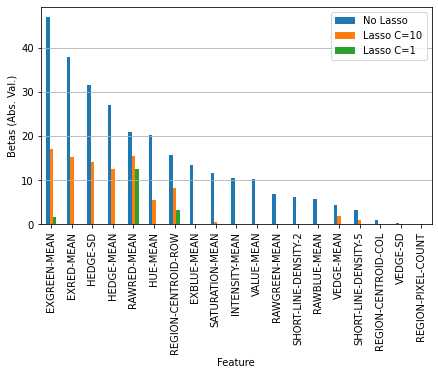

In [18]:
df_plot = f_scores.sort_values('No Lasso', ascending = False)
ax = df_plot[['No Lasso','Lasso C=10','Lasso C=1']].plot.bar(figsize=(7,4))
ax.grid( axis = 'y')
plt.ylabel('Betas (Abs. Val.)')

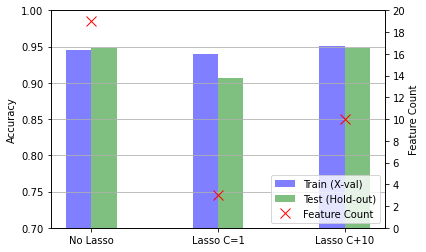

In [19]:
fig, ax = plt.subplots()
width = 0.2

options = ['No Lasso', 'Lasso C=1', 'Lasso C+10']
n_feat = [X_train.shape[1], len(lasso_def_features), len(lasso_mild_features)]
accs = [full_acc,default_acc,mild_acc]
xv = [full_tr_acc.mean(), def_tr_acc.mean(), mild_tr_acc.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label = 'Train (X-val)',
            color=['blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width/2, accs , width, align='center', label = 'Test (Hold-out)',
            color=['g','g','g'],alpha=0.5)

ax.set_ylim([0.7, 1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2],n_feat, color = 'red', label = 'Feature Count',
              marker = 'x', ms = 10, linewidth=0)
ax2.set_ylim([0, 20])

ax.grid(axis = 'y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Feature Count')

plt.show()

## Penguins dataset
Lasso feature selection on the Penguins dataset

In [20]:
penguins = pd.read_csv('penguins.csv', index_col = 0)
print(penguins.shape)
penguins.head()

(333, 5)


,bill_length,bill_depth,flipper_length,body_mass,species
0,39.1,18.7,181.0,3750.0,Adelie
1,39.5,17.4,186.0,3800.0,Adelie
2,40.3,18.0,195.0,3250.0,Adelie
3,36.7,19.3,193.0,3450.0,Adelie
4,39.3,20.6,190.0,3650.0,Adelie


In [21]:
classes=np.unique(penguins['species'])
classes

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

Reduce to a 2-class dataset to make Lasso feature selection more transparent. 

In [22]:
penguins2C = penguins.loc[penguins['species'].isin(['Adelie','Chinstrap'])]

In [23]:
y = penguins2C.pop('species').values
X_raw = penguins2C.values
feature_names = penguins2C.columns
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, random_state=2, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
max_k = X_train.shape[1]
X_train.shape, X_test.shape

((107, 4), (107, 4))

### Logistic Regression

In [24]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=5000)
lr_tr = lr.fit(X_train, y_train)
full_acc = lr_tr.score(X_test, y_test)
full_tr_acc = cross_val_score(lr, X_train, y_train, cv=8)
print('Test Accuracy: {:.2f}'.format(full_acc), 
      'Training Accuracy: {:.2f}'.format(full_tr_acc.mean()))

Test Accuracy: 0.98 Training Accuracy: 0.99


In [25]:
betas = np.absolute(lr_tr.coef_[0])
f_scores=pd.DataFrame({'No Lasso':betas,'Feature':feature_names})
f_scores.set_index('Feature', inplace = True)
f_scores

,No Lasso
Feature,
bill_length,78.310405
bill_depth,18.720460
flipper_length,2.904586
body_mass,25.952054


### Lasso feature selection
Logistic regression with L1 regularisation.   
`SelectFromModel` will select the top features out of `max_features`   
The `C` parameter in `LogisticRegression` is the regularisation parameter, smaller values means stronger regularisation, default is 1.       
You can select a specific number of features from `SelectFromModel` using the `max_features` parameter

### Using default regularisation


In [26]:
lasso = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=1, solver="saga", max_iter=1000), max_features=X_train.shape[1])
lasso.fit(X_train, y_train)
lasso_def_features = list(penguins2C.columns[lasso.get_support()])
print('Selected features:', lasso_def_features)

Selected features: ['bill_length', 'body_mass']


In [27]:
f_scores['Lasso C=1'] = np.absolute(lasso.estimator_.coef_[0])

Reduce the data to just the selected features

In [28]:
X_tr_def = lasso.transform(X_train)
X_tst_def = lasso.transform(X_test)
X_tr_def.shape, X_tst_def.shape

((107, 2), (107, 2))

In [29]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=4000)
lr_def = lr.fit(X_tr_def, y_train)
default_acc = lr_def.score(X_tst_def, y_test)
def_tr_acc = cross_val_score(lr, X_tr_def, y_train, cv=8)
print('Lasso C=1 selects %d features' % (X_tr_def.shape[1]))
print('Lasso C=1 Test Accuracy: {:.2f}'.format(default_acc), 
      'Lasso C=1 Train Accuracy (x-val): {:.2f}'.format(def_tr_acc.mean()))

Lasso C=1 selects 2 features
Lasso C=1 Test Accuracy: 0.96 Lasso C=1 Train Accuracy (x-val): 0.99


### Using less regularisation

In [30]:
lasso_mild = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=10, solver="saga", max_iter=3000), max_features=X_train.shape[1])
lasso_mild.fit(X_train, y_train)
lasso_mild_features = list(penguins2C.columns[lasso_mild.get_support()])
print('Selected features:', lasso_mild_features)

Selected features: ['bill_length', 'bill_depth', 'body_mass']


In [31]:
f_scores['Lasso C=10'] = np.absolute(lasso_mild.estimator_.coef_[0])

In [32]:
X_tr_mild = lasso_mild.transform(X_train)
X_tst_mild = lasso_mild.transform(X_test)
X_tr_mild.shape, X_tst_mild.shape

((107, 3), (107, 3))

In [33]:
lr = LogisticRegression(solver='saga', penalty='none', max_iter=4000)
lr_mild = lr.fit(X_tr_mild, y_train)
mild_acc = lr_mild.score(X_tst_mild, y_test)
mild_tr_acc = cross_val_score(lr, X_tr_mild, y_train, cv=8)
print('Lasso C=10 selects %d features' % (X_tr_mild.shape[1]))
print('Lasso C=10 Test Accuracy: {:.2f}'.format(mild_acc), 
      'Lasso C=10 Train Accuracy (x-val): {:.2f}'.format(mild_tr_acc.mean()))

Lasso C=10 selects 3 features
Lasso C=10 Test Accuracy: 0.98 Lasso C=10 Train Accuracy (x-val): 1.00


### Plotting results

In [34]:
f_scores.head()

,No Lasso,Lasso C=1,Lasso C=10
Feature,,,
bill_length,78.310405,12.840174,32.348929
bill_depth,18.720460,0.000000,3.938317
flipper_length,2.904586,0.000000,0.000000
body_mass,25.952054,2.292063,9.366021


Text(0, 0.5, 'Betas (Abs. Val.)')

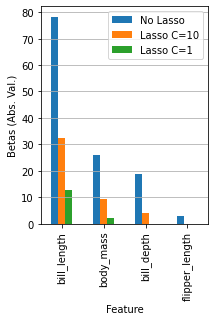

In [35]:
df_plot = f_scores.sort_values('No Lasso', ascending = False)
ax = df_plot[['No Lasso','Lasso C=10','Lasso C=1']].plot.bar(figsize=(3,4))
ax.grid( axis = 'y')
plt.ylabel('Betas (Abs. Val.)')

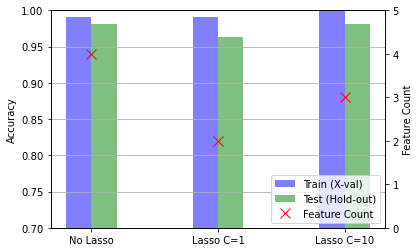

In [36]:
fig, ax = plt.subplots()
width = 0.2

options = ['No Lasso', 'Lasso C=1', 'Lasso C=10']
n_feat = [X_train.shape[1], len(lasso_def_features), len(lasso_mild_features)]
accs = [full_acc,default_acc,mild_acc]
xv = [full_tr_acc.mean(), def_tr_acc.mean(), mild_tr_acc.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label = 'Train (X-val)',
            color=['blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width/2, accs , width, align='center', label = 'Test (Hold-out)',
            color=['g','g','g'],alpha=0.5)

ax.set_ylim([0.7, 1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2],n_feat, color = 'red', label = 'Feature Count',
              marker = 'x', ms = 10, linewidth=0)
ax2.set_ylim([0, 5])

ax.grid(axis = 'y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Feature Count')

plt.show()